In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tests import test_prediction, test_generation

In [2]:
# load all that we need
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataset = np.load('../dataset/wiki.train.npy')
fixtures_pred = np.load('../fixtures/prediction.npz')  # dev
fixtures_gen = np.load('../fixtures/generation.npy')  # dev
fixtures_pred_test = np.load('../fixtures/prediction_test.npz')  # test
fixtures_gen_test = np.load('../fixtures/generation_test.npy')  # test
vocab = np.load('../dataset/vocab.npy')
vocab
# print(vocab.dtype)

array(['!', '"', '#', ..., '火礮', '\ufeff', '～'], dtype='<U20')

In [3]:
# data loader

class LanguageModelDataLoader(DataLoader):
    """
        TODO: Define data loader logic here
    """
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        # self.indexes = np.arange(len(dataset))
        self.seq_len = np.array([len(st) for st in self.dataset])
        self.mean = np.mean(self.seq_len)
        self.var = np.var(self.seq_len)

        
    def __iter__(self):
        # concatenate your articles and build into batches
        pack = self.dataset.copy()
        if self.shuffle:
            self.indexes = np.random.permutation(len(pack))
        else:
            self.indexes = np.arange(len(pack))
        pack = np.concatenate(pack[self.indexes])
        truncate = len(pack) % self.batch_size
        pack = pack[:-truncate]
        pack = pack.reshape(self.batch_size, -1)
        
        self.X = pack[:,:-1] ; self.Y = pack[:, 1:]
        idx = 0
        while True:
            if np.random.binomial(1, 0.95):
                s = int(np.random.normal(70, 5))
            else:
                s = int(np.random.normal(35, 5))
            if idx + s > self.X.shape[1]:
                yield (torch.from_numpy(self.X[:, idx:].transpose()).long(), torch.from_numpy(self.Y[:, idx:].transpose()).long())
                break
            else:
                yield (torch.from_numpy(self.X[:, idx:idx+s].transpose()).long(), torch.from_numpy(self.Y[:, idx:idx+s].transpose()).long())
                idx += s

                
# train_loader = LanguageModelDataLoader(dataset, 80)
# for e in range(10):
#     for i, (inputs,targets) in enumerate(train_loader):
#         print(inputs.size(), targets.size())




In [4]:
class WeightDrop(nn.Module):
    """Implenmentation from salesforce"""
    
    def __init__(self, module, weights, dropout=0, variational=False):
        super(WeightDrop, self).__init__()
        self.module = module
        self.weights = weights
        self.dropout = dropout
        self.variational = variational
        self._setup()

    def widget_demagnetizer_y2k_edition(*args, **kwargs):
        # We need to replace flatten_parameters with a nothing function
#         It must be a function rather than a lambda as otherwise pickling explodes
        # We can't write boring code though, so ... WIDGET DEMAGNETIZER Y2K EDITION!
        # (╯°□°）╯︵ ┻━┻
        return

    def _setup(self):
        # Terrible temporary solution to an issue regarding compacting weights re: CUDNN RNN
        if issubclass(type(self.module), torch.nn.RNNBase):
            self.module.flatten_parameters = self.widget_demagnetizer_y2k_edition

        for name_w in self.weights:
            print('Applying weight drop of {} to {}'.format(self.dropout, name_w))
            w = getattr(self.module, name_w)
            del self.module._parameters[name_w]
            self.module.register_parameter(name_w + '_raw', nn.Parameter(w.data))

    def _setweights(self):
        for name_w in self.weights:
            raw_w = getattr(self.module, name_w + '_raw')
            w = None
            if self.variational:
                mask = torch.autograd.Variable(torch.ones(raw_w.size(0), 1))
                if raw_w.is_cuda: mask = mask.cuda()
                mask = torch.nn.functional.dropout(mask, p=self.dropout, training=True)
                w = nn.Parameter(mask.expand_as(raw_w) * raw_w)
            else:
                w = nn.Parameter(torch.nn.functional.dropout(raw_w, p=self.dropout, training=self.training))
            setattr(self.module, name_w, w)

    def forward(self, *args):
        self._setweights()
        return self.module.forward(*args)
    

In [5]:
class LockedDropout(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, dropout=0.5):
        if dropout == 0 or not self.training:
            return x 
        mask = x.data.new(x.size(0), 1, x.size(2))
        mask = mask.bernoulli_(1 - dropout)
        mask = Variable(mask, requires_grad=False) / (1 - dropout)
        mask = mask.expand_as(x)
        return mask * x
    

In [6]:
def embedded_dropout(embed, words, dropout=0.1, scale=None):
    if dropout:
        mask = embed.weight.data.new().resize_((embed.weight.size(0), 1)).bernoulli_(1 - dropout).expand_as(embed.weight) / (1 - dropout)
        masked_embed_weight = mask * embed.weight
    else:
        masked_embed_weight = embed.weight
    if scale:
        masked_embed_weight = scale.expand_as(masked_embed_weight) * masked_embed_weight

    padding_idx = embed.padding_idx
    if padding_idx is None:
        padding_idx = -1

    X = torch.nn.functional.embedding(words, masked_embed_weight,
    padding_idx, embed.max_norm, embed.norm_type,
    embed.scale_grad_by_freq, embed.sparse
    )
    return X

In [7]:
# model

class LanguageModel(nn.Module):
    """
        TODO: Define your model here
    """
    def __init__(self, vocab_size, embedding_size=400, hidden_size=1150, n_layers=3, tie_weights=False):
        super(LanguageModel, self).__init__()
        
        self.embedding_size = embedding_size
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.tie_weights = tie_weights
        
        self.lockdrop = LockedDropout()
        self.encoder = nn.Embedding(vocab_size, embedding_size)
        self.rnns = [nn.LSTM(embedding_size if l == 0 else hidden_size, hidden_size \
                    if l != n_layers-1 else (embedding_size if tie_weights else hidden_size), 1, dropout=0)for l in range(n_layers)]
        self.rnns = [WeightDrop(rnn, ['weight_hh_l0'], dropout=0.5) for rnn in self.rnns]
        print(self.rnns)
        self.rnns = nn.ModuleList(self.rnns)
        self.decoder = nn.Linear(embedding_size if tie_weights else hidden_size, vocab_size)
        if tie_weights:
            self.decoder.weight = self.encoder.weight
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-initrange, initrange)
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        return [(weight.new(1, batch_size, self.hidden_size if l != self.n_layers - 1 else (self.embedding_size if self.tie_weights else self.hidden_size)).zero_(),
                    weight.new(1, batch_size, self.hidden_size if l != self.n_layers - 1 else (self.embedding_size if self.tie_weights else self.hidden_size)).zero_())
                    for l in range(self.n_layers)]
    
    def repackage_hidden(self, h):
        """Wraps hidden states in new Tensors,
        to detach them from their history."""
        if isinstance(h, torch.Tensor):
            return h.detach()
        else:
            return tuple(self.repackage_hidden(v) for v in h)
    
    def forward(self, inputs):
        # input: input tensor of shape [seq_len x batch_size]
        # hidden: a list of (h_init, c_init), each element has shape (n_layers x num_directions, batch_size, hidden_size)
        hidden = None
        batch_size = inputs.size(1)
        # emb = self.encoder(inputs)
        emb = embedded_dropout(self.encoder, inputs, dropout=0.1 if self.training else 0)
        emb = self.lockdrop(emb, 0.65)
        raw_output = emb
        new_hidden = []
        for l, rnn in enumerate(self.rnns):
            current_input = raw_output
            raw_output, new_h = rnn(raw_output, hidden)
            new_hidden.append(new_h)
            if l != self.n_layers-1:
                raw_output = self.lockdrop(raw_output, 0.3)
        hidden = new_hidden
        output = self.lockdrop(raw_output, 0.4)
        # flatten the output
        output = output.view(output.size(0)*output.size(1), output.size(2))
        output = self.decoder(output)

        return output.view(-1, batch_size, self.vocab_size), hidden
        # Feel free to add extra arguments to forward (like an argument to pass in the hiddens)
    

In [8]:
# model trainer

class LanguageModelTrainer:
    def __init__(self, model, loader, max_epochs=1, run_id='exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model = model
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.predictions = []
        self.predictions_test = []
        self.generated_logits = []
        self.generated = []
        self.generated_logits_test = []
        self.generated_test = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id
        
        # TODO: Define your optimizer and criterion here
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=30, weight_decay=1.2e-6)
        self.criterion = nn.CrossEntropyLoss(reduction='sum')
        self.batch_size = self.loader.batch_size
        # self.hidden = self.model.init_hidden(batch_size)
        self.model = self.model.to(device)
        self.criterion = self.criterion.to(device)
        
        # boom time
        torch.backends.cudnn.benchmark=True

    def sample_gumbel(self, shape, eps=1e-20):
        U = torch.rand(shape).to(device)
        return -Variable(torch.log(-torch.log(U+eps)+eps), requires_grad=False).to(device)

    def gumbel_logits(self, logits, temperature=0.8):
        y = logits + self.sample_gumbel(logits.size())
        return y/temperature
        
    def train(self):
        self.model.train() # set to training mode
        epoch_loss = 0
        num_batches = 0
        for batch_num, (inputs, targets) in enumerate(self.loader):
            epoch_loss += self.train_batch(inputs, targets)
        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss)

    def train_batch(self, inputs, targets):
        """ 
            TODO: Define code for training a single batch of inputs
        
        """
        #         U = torch.rand((inputs.size(0), inputs.size(1), self.model.vocab_size)).to(device)
        #         U = -Variable(torch.log(-torch.log(U+1e-20)+1e-20), requires_grad=False)
        #         U = U.to(device)
        inputs = inputs.to(device)
        targets = targets.to(device)

        self.optimizer.zero_grad()
        outputs, hidden = self.model(inputs)
        outputs = self.gumbel_logits(outputs)
        #         outputs = (outputs + U)/0.8
        loss = self.criterion(outputs.view(-1, outputs.size(2)), targets.view(-1))/(self.batch_size*inputs.size(1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.25)
        self.optimizer.step()
        return loss.item()

    def test(self):
        # don't change these
        self.model.eval() # set to eval mode
        predictions = TestLanguageModel.prediction(fixtures_pred['inp'], self.model) # get predictions
        self.predictions.append(predictions)
        generated_logits = TestLanguageModel.generation(fixtures_gen, 10, self.model) # generated predictions for 10 words
        generated_logits_test = TestLanguageModel.generation(fixtures_gen_test, 10, self.model)
        nll = test_prediction(predictions, fixtures_pred['out'])
        generated = test_generation(fixtures_gen, generated_logits, vocab)
        generated_test = test_generation(fixtures_gen_test, generated_logits_test, vocab)
        self.val_losses.append(nll)
        
        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)
        
        # generate predictions for test data
        predictions_test = TestLanguageModel.prediction(fixtures_pred_test['inp'], self.model) # get predictions
        self.predictions_test.append(predictions_test)
            
        print('[VAL]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs, self.max_epochs, nll))
        return nll

    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
            model_path)
        np.save(os.path.join('experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w', encoding="utf-8") as fw:
            fw.write(self.generated[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w', encoding="utf-8") as fw:
            fw.write(self.generated_test[-1])


In [9]:
class TestLanguageModel:
    def prediction(inp, model):
        """
            TODO: write prediction code here
            
            :param inp:
            :return: a np.ndarray of logits
        """
        
        # generally speaking, it will be faster to decompose the model and
        # perform the calculation separately, but since this is a very short 
        # sequence, I got lazy and just use the forward method.
        # same thing happens during generation
        inputs = torch.from_numpy(inp.transpose()).long().to(device)
        outputs, hidden = model(inputs)
        output = outputs[-1]
        return output.data.cpu().numpy()
        
    def generation(inp, forward, model):
        """
            TODO: write generation code here

            Generate a sequence of words given a starting sequence.
            :param inp: Initial sequence of words (batch size, length)
            :param forward: number of additional words to generate
            :return: generated words (batch size, forward)
        """
        generated = []
        inputs = torch.from_numpy(inp.transpose()).long().to(device)
        outputs, hidden = model(inputs)
        output = outputs[-1]
        U = torch.rand(output.size())
        U = -torch.log(-torch.log(U+1e-20)+1e-20).to(device)
        output = output + U
        _, current_word = torch.max(output, dim=1)
        generated.append(current_word.data.cpu().numpy())
        current_word = current_word.unsqueeze(0)
        if forward > 1:
            for i in range(forward-1):
                outputs, hidden = model(current_word)
                output = outputs[0]
                U = torch.rand(output.size())
                U = -torch.log(-torch.log(U+1e-20)+1e-20).to(device)
                output = output + U
                _, current_word = torch.max(output, dim=1)
                generated.append(current_word.data.cpu().numpy())
                current_word = current_word.unsqueeze(0)
                # if current_word
        return np.array(generated).transpose()
  

In [10]:
# TODO: define other hyperparameters here

NUM_EPOCHS = 10
BATCH_SIZE = 80


In [11]:
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

Saving models, predictions, and generated words to ./experiments/1554784403


In [12]:
model = LanguageModel(len(vocab))
loader = LanguageModelDataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
trainer = LanguageModelTrainer(model=model, loader=loader, max_epochs=NUM_EPOCHS, run_id=run_id)

Applying weight drop of 0.5 to weight_hh_l0
Applying weight drop of 0.5 to weight_hh_l0
Applying weight drop of 0.5 to weight_hh_l0
[WeightDrop(
  (module): LSTM(400, 1150)
), WeightDrop(
  (module): LSTM(1150, 1150)
), WeightDrop(
  (module): LSTM(1150, 1150)
)]


In [13]:
best_nll = 1e30 
for epoch in range(NUM_EPOCHS):
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch)+" with NLL: "+ str(best_nll))
        trainer.save()
    

c:\program files\python36\lib\site-packages\torch\nn\modules\module.py:477: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  result = self.forward(*input, **kwargs)


[TRAIN]  Epoch [1/10]   Loss: 9.3250
[VAL]  Epoch [1/10]   Loss: 6.6466
Saving model, predictions and generated output for epoch 0 with NLL: 6.6465964
[TRAIN]  Epoch [2/10]   Loss: 8.1464
[VAL]  Epoch [2/10]   Loss: 5.9108
Saving model, predictions and generated output for epoch 1 with NLL: 5.9108276
[TRAIN]  Epoch [3/10]   Loss: 7.6550
[VAL]  Epoch [3/10]   Loss: 5.4812
Saving model, predictions and generated output for epoch 2 with NLL: 5.481227
[TRAIN]  Epoch [4/10]   Loss: 7.3678
[VAL]  Epoch [4/10]   Loss: 5.1233
Saving model, predictions and generated output for epoch 3 with NLL: 5.123341
[TRAIN]  Epoch [5/10]   Loss: 7.0492
[VAL]  Epoch [5/10]   Loss: 5.0906
Saving model, predictions and generated output for epoch 4 with NLL: 5.0905848
[TRAIN]  Epoch [6/10]   Loss: 6.8808
[VAL]  Epoch [6/10]   Loss: 4.8916
Saving model, predictions and generated output for epoch 5 with NLL: 4.891618
[TRAIN]  Epoch [7/10]   Loss: 6.7612
[VAL]  Epoch [7/10]   Loss: 4.8202
Saving model, predictions

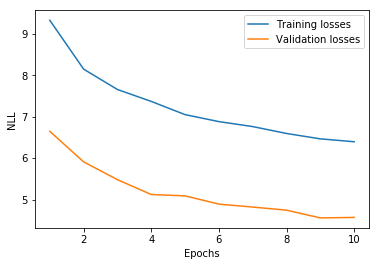

In [14]:
# Don't change these
# plot training curves
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [25]:
trainer.save()

In [15]:
# see generated output
print (trainer.generated[-1]) # get last generated output

Input | Output #0: while the group was en route , but only three were ultimately able to attack . None of them were | successful " eternal influence to the episode retired on the
Input | Output #1: <unk> , where he remained on loan until 30 June 2010 . <eol> = = = Return to Manchester United | = = = = = = Sub @-@ disguised the
Input | Output #2: 25 April 2013 , denoting shipments of 500 @,@ 000 copies . <eol> The song became One Direction 's fourth | single did not 370 ( <unk> activity the Sinai Water
Input | Output #3: , and Bruce R. ) one daughter ( Wendy J. <unk> ) and two grandchildren , died in <unk> , | anarchy , but without a declaration , in an instrument
Input | Output #4: Warrior were examples of this type . Because their armor was so heavy , they could only carry a single | ( veneration from <unk> , and understated differing risen as
Input | Output #5: the embassy at 1 : 49 and landed on Guam at 2 : 23 ; twenty minutes later , Ambassador | , with ten miles ( ARIA for the eye